# Rotating Sinusoidal bump

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
def get_rotating_sine(time: int, num_neurons: int, period: int):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(num_neurons))
	theta = x*period/num_neurons - t
	return (1+torch.sin(2.0*math.pi/period * theta)) / 2

def convert_to_spikes(x: torch.Tensor, noise_ratio: float=0.0):
	return torch.rand_like(x) < (noise_ratio*torch.rand_like(x) + (1.0-noise_ratio)*(x / x.max()))

def sum_by_index(data: torch.Tensor, indices: torch.Tensor):
	return torch.zeros(indices.max().numpy()+1).index_add(0,indices.flatten(),data.flatten().float())

def roll_tensor_rows(tensor, roll_amounts):
	tensor_rolled = tensor[:, [*range(tensor.shape[1]),*range(tensor.shape[1]-1)]].clone()
	stride_0, stride_1 = tensor_rolled.stride()
	num_cols = tensor.shape[1]
	result = torch.as_strided(tensor_rolled, (*tensor.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[torch.arange(tensor.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_time_periodic_profile(data: torch.Tensor, period: int):
	'''
	Return the average periodic spiking profile for the network (shifted so the centre angle is in the middle)

	:param data: Spiking output of the network [time*neurons]
	:param period: Period of the sine wave signal
	'''
	neurons = data.shape[1]
	shifts = -torch.arange(neurons) * period // neurons
	return torch.roll(torch.stack(torch.split(roll_tensor_rows(data.T, shifts), period, dim=1)).sum(dim=0).sum(dim=0), period//2)

def get_weight_periodic_profile(weights: torch.Tensor):
	'''
	Return the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.mean(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0), neurons//2)

Create the input for the network

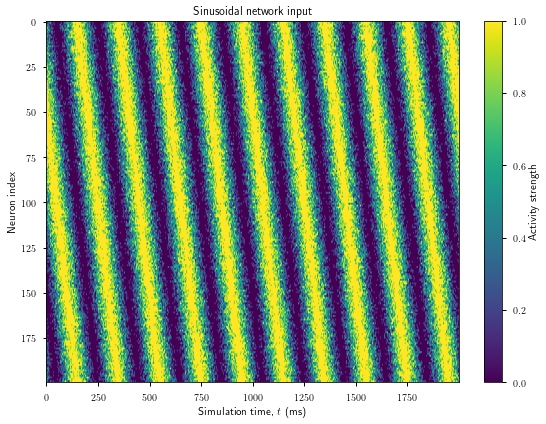

In [3]:
time = 2000
num_neurons = 200
period = 200
input_noise_ratio = 0.

t, x = torch.meshgrid(torch.arange(time),torch.arange(num_neurons))
input_voltage = get_rotating_sine(time, num_neurons, period)
input_spikes = convert_to_spikes(input_voltage, input_noise_ratio)

im = plt.imshow(input_spikes.T)
plt.axis('auto')
plt.title('Sinusoidal network input')
plt.ylabel('Neuron index')
plt.xlabel('Simulation time, $t$ (ms)')
plt.colorbar(im, label='Activity strength')
plt.tight_layout()
plt.show()

Create the network of LIF neurons with homeostatic+STDP plasticity. Weights are constrained to be nonnegative.

In [4]:
def set_learning_rates(connection, nu, gamma):
	connection.update_rule.nu = torch.Tensor([nu,nu])
	connection.update_rule.gamma = gamma

def create_and_run_network(nu=1e-2, gamma=1e-4):
	network = Network()

	# Create and add input, output layers.
	lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

	network.add_layer(layer=lif_layer, name='LIF')

	initial_weights = 0.05 * (torch.rand((lif_layer.n,lif_layer.n)))
	initial_weights_copy = initial_weights.clone()
	recurrent_connection = Connection(
		source=lif_layer,
		target=lif_layer,
		update_rule = HomeostaticSTDP,
		nu=0,
		gamma = 0,
		wmin=0,
		w=initial_weights,
	)
	network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')

	# Create and add monitors for spikes and voltages
	monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=time)
	network.add_monitor(monitor=monitor, name='LIF_monitor')

	# Simulate network on input data - need input to be strong enough to cause spiking
	# run the network without learning for 1 s (before), then with learning for 3 s, then without learning for another second (after)
	# we then compare the results before and after learning
	input_weight = 4
	set_learning_rates(recurrent_connection, nu, gamma)
	network.run(inputs={'LIF': input_weight*input_spikes}, time=time, progress_bar=True)

	# Retrieve data from monitors for analysis
	spikes = monitor.get('s')
	voltages = monitor.get('v')
	rates = monitor.get('r')

	return spikes, voltages, rates, recurrent_connection.w

Replicating Figure 3 (bottom right):
The initial weights are random, but the profiles after learning (centred relative to each neuron and averaged) show a roughly sinusoidal shape

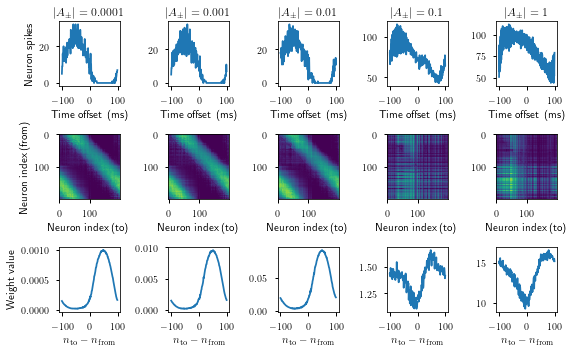

In [5]:
# A_range = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
A_range = [1e-4, 1e-3, 1e-2, 1e-1, 1]

fig, axs = plt.subplots(3,len(A_range), figsize=(8,5))

axs[0,0].set_ylabel('Neuron spikes')
axs[1,0].set_ylabel('Neuron index (from)')
axs[2,0].set_ylabel(r'Weight value')

for A, ax in zip(A_range, axs.T):
	spikes, voltages, rates, w = create_and_run_network(A, 1e-4)

	# bindsnet.analysis.plotting.plot_spikes({"LIF": spikes})
	# plt.title('Network spikes during learning')
	# plt.xticks(np.arange(0,5001,1000))
	# plt.xlabel('Simulation time, $t$ (ms)')
	# plt.tight_layout()
	# # plt.savefig('plots/sinusoidal-simulation-raster.pdf')
	# plt.show()
	ax[0].set_title(f'$|A_\pm| = {A}$')
	ax[0].plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes[-period:,:].squeeze(), period))
	ax[0].set_xlabel('Time offset (ms)')

	img = ax[1].imshow(w, aspect='auto')
	ax[1].set_xlabel('Neuron index (to)')

	weight_profile = get_weight_periodic_profile(w)
	weight_profile[num_neurons//2] = np.nan
	ax[2].plot(torch.arange(-num_neurons/2,num_neurons/2), weight_profile, label='After learning')
	ax[2].set_xlabel(r'$n_{\rm{to}} - n_{\rm{from}}$')
	
plt.tight_layout()
plt.savefig('plots/output-weight-magnitudes-kernel-magnitude-sinusoid.pdf')
plt.show()

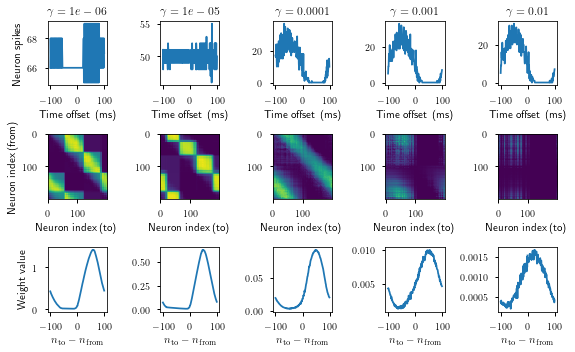

In [6]:
gamma_range = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

fig, axs = plt.subplots(3,len(gamma_range), figsize=(8,5))

axs[0,0].set_ylabel('Neuron spikes')
axs[1,0].set_ylabel('Neuron index (from)')
axs[2,0].set_ylabel(r'Weight value')

for gamma, ax in zip(gamma_range, axs.T):
	spikes, voltages, rates, w = create_and_run_network(1e-2, gamma)

	# bindsnet.analysis.plotting.plot_spikes({"LIF": spikes})
	# plt.title('Network spikes during learning')
	# plt.xticks(np.arange(0,5001,1000))
	# plt.xlabel('Simulation time, $t$ (ms)')
	# plt.tight_layout()
	# # plt.savefig('plots/sinusoidal-simulation-raster.pdf')
	# plt.show()
	ax[0].set_title(f'$\gamma = {gamma}$')
	ax[0].plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes[-period:,:].squeeze(), period))
	ax[0].set_xlabel('Time offset (ms)')

	img = ax[1].imshow(w, aspect='auto')
	ax[1].set_xlabel('Neuron index (to)')

	weight_profile = get_weight_periodic_profile(w)
	weight_profile[num_neurons//2] = np.nan
	ax[2].plot(torch.arange(-num_neurons/2,num_neurons/2), weight_profile, label='After learning')
	ax[2].set_xlabel(r'$n_{\rm{to}} - n_{\rm{from}}$')
	
plt.tight_layout()
plt.savefig('plots/output-weight-magnitudes-gamma-sinusoid.pdf')
plt.show()

Examining the neuron firing rate traces - the neurons converge to firing at ~55 Hz

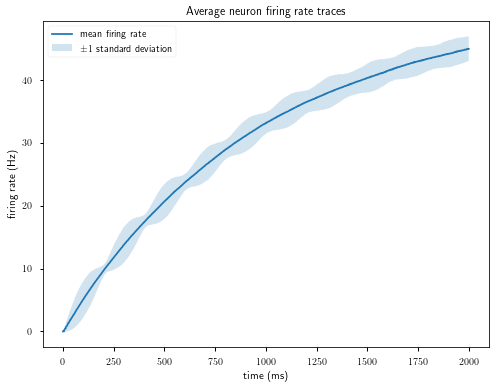

In [7]:
avg = rates.squeeze().mean(dim=1)
stdev = torch.sqrt(rates.squeeze().var(dim=1))
plt.plot(avg)
plt.fill_between(torch.arange(time), avg-stdev, avg+stdev, alpha=0.2)
plt.legend(['mean firing rate','$\\pm1$ standard deviation'])
plt.title('Average neuron firing rate traces')
plt.xlabel('time (ms)')
plt.ylabel('firing rate (Hz)')
plt.show()